In [1]:
import pandas as pd
import numpy as np

/var/folders/zp/c97k147160ddnklbfc2rk3hr0000gn/T/ipykernel_11689/2162656668.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_pickle('data/SBAmodel.pickle')
pd.set_option('display.max_columns', None)
df.head(1)

,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,1997-02-28,1997,84,4,1,0,0,1,0,0,0,1,60000.0


# Tune variables

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.BankState = le.fit_transform(df.loc[:,['BankState']])
df.BankState = df.BankState.astype('category')

df['immo'] = np.where(df['Term'] >= 240, 1, 0)
df

/Users/maximekuil/Documents/Simplon/US-SBA/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,MIS_Status,GrAppv,immo
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,38,45,1997-02-28,1997,84,4,1,0,0,1,0,0,0,1,60000.0,0
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,18,72,1997-02-28,1997,60,2,1,0,0,1,0,0,0,1,40000.0,0
2,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,18,62,1997-02-28,1997,180,7,0,0,0,1,0,0,0,1,287000.0,0
3,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,39,0,1997-02-28,1997,60,2,0,0,0,1,0,0,0,1,35000.0,0
4,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,11,0,1997-02-28,1997,240,14,0,7,7,1,0,0,0,1,229000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,17,45,1997-02-27,1997,60,6,0,0,0,1,0,1,0,1,70000.0,0
899160,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,17,45,1997-02-27,1997,60,6,0,0,0,1,0,1,0,1,85000.0,0
899161,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",5,33,1997-02-27,1997,108,26,0,0,0,1,0,0,0,1,300000.0,0
899162,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,14,0,1997-02-27,1997,60,6,0,0,0,1,0,0,0,0,75000.0,0


# Split

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['MIS_Status'])
y = df.MIS_Status

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=69
)

X_train.head(1)

(719331, 20)
(179833, 20)
(899164, 20)


## pipeline

In [24]:
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FunctionTransformer, make_pipeline
from feature_engine.selection import DropFeatures

from xgboost import XGBClassifier

set_config(transform_output = "pandas")

drop = DropFeatures(features_to_drop=['Name', 'City', 'Bank', 'State', 'LowDoc'])#, 'NewExist'])
transformers = ColumnTransformer(
    transformers = [
        ('date', FunctionTransformer(lambda x: x.astype(int)), ['ApprovalDate'])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

scaler = StandardScaler()
# estimator = XGBClassifier(n_estimators=5, max_depth=5)
estimator = RandomForestClassifier(max_depth=3)

pipe = make_pipeline(
            drop,
            transformers,
            scaler,
            estimator)

pipe.fit(X_train, y_train)

Pipeline(steps=[('dropfeatures',
                 DropFeatures(features_to_drop=['Name', 'City', 'Bank', 'State',
                                                'LowDoc'])),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  FunctionTransformer(func=<function <lambda> at 0x152fe8180>),
                                                  ['ApprovalDate'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=3))])

## Score

In [25]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))


model = pipe.named_steps['randomforestclassifier']

              precision    recall  f1-score   support

           0       0.88      0.23      0.36     31512
           1       0.86      0.99      0.92    148321

    accuracy                           0.86    179833
   macro avg       0.87      0.61      0.64    179833
weighted avg       0.86      0.86      0.82    179833



# Matrice de confusion

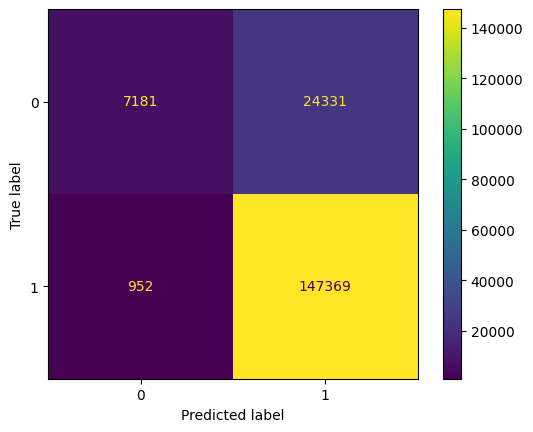

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cf_matrix).plot()

### Feature importance

In [27]:
from utils import feature_importance


f, X_train_transf = feature_importance(X_train, y_train, model, pipe)
f

,features,score %
5,Term,44.79
0,ApprovalDate,16.71
4,ApprovalFY,15.10
10,FranchiseCode,5.77
14,immo,5.05
11,UrbanRural,4.02
9,RetainedJob,3.49
13,GrAppv,2.82
3,NAICS,0.76
2,BankState,0.46


In [28]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = model,
    X = X_train_transf,
    y = y_train,
    train_sizes = np.linspace(0.01, 1, 10),
    cv = 3,
    scoring = 'f1_macro',
    n_jobs=-1
)

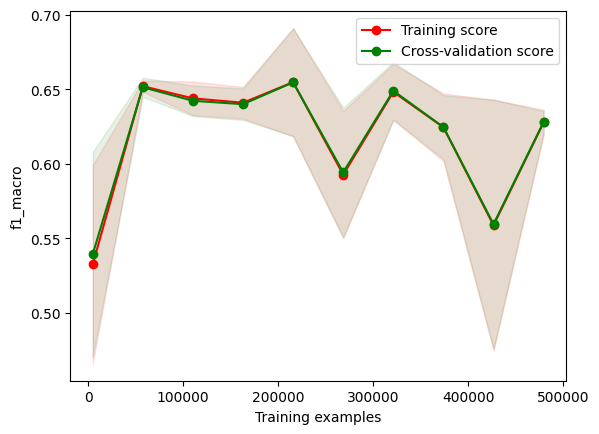

In [29]:
import matplotlib.pyplot as plt

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(validation_scores, axis=1)
test_std = np.std(validation_scores, axis=1)

# afficher les points
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

# relier les points
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.xlabel("Training examples")
plt.ylabel("f1_macro")

plt.legend()